This notebook evaluates the correctness of AZKAG for our method based on biclique-graph-patterns and the classical method based on frequent-patterns. We report Recall, Precision and F-score using two types of synthetic examples for the negatives: from random sampling, and from our generation procedure. We also report some statitics about the resulting examples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from src import avpattern as avp
from efficient_apriori import apriori


### Load access control graph

In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


In [3]:
#Get attribute-values of users
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)
userlog_objs = ut.to_tuple_format(userlog_objs)

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

### Useful functions

In [50]:
def plot_bins(usrvidx_resvidx_tups):
    
    idxs_entry_events = []
    for v in gur.vs:
        if v['type']:
            idx = v.index - len(usrlabels)
            for _ in range(gur.degree(v)):
                idxs_entry_events.append(idx)
    
    
    idxs_example_events = []
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        idx = resvidx - len(usrlabels)
        idxs_example_events.append(idx)
        
    
    bins = np.linspace(0, len(reslabels), 50)
    plt.hist(idxs_entry_events,bins=bins,color='tab:blue', density=True)
    plt.hist(idxs_example_events,bins=bins,color='tab:red', alpha=0.4, density=True)
    plt.plot()
    
def cov_resources(usrvidx_resvidx_tups):
    residxsset = set()
    for tup in usrvidx_resvidx_tups:
        resvidx = tup[1]
        residxsset.add(resvidx)
        
    return len(residxsset)/len(reslabels)

In [7]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [8]:
def next_vertex(gur, v):
    neighvidxs = gur.neighbors(v)
    i = random.randint(0,len(neighvidxs)-1)
    return gur.vs[neighvidxs[i]]
    

def get_entry_tupes(gur, max_hops, alpha, sd):
    random.seed(sd)
    usrvidx_resvidx_tups = list()
    
    for v in gur.vs:
        if v['type']: #Only resources
            neighvidxsset = set(gur.neighbors(v))
            deg = len(neighvidxsset)
            usrvidxsset = set()

            count = 0
            while len(usrvidxsset) < alpha*deg:
                v_ = v
                for i in range(max_hops):
                    v2 = next_vertex(gur, v_)
                    if i == max_hops-1 and not v2.index in neighvidxsset:
                        usrvidxsset.add(v2.index)
                    else:
                        v_ = v2
                count += 1
                
                if count > 100000:
                    break
                    
            for usrvidx in list(usrvidxsset):
                usrvidx_resvidx_tups.append((usrvidx,v.index))
        
    return usrvidx_resvidx_tups


def filter_sim(gur, usrvidx_resvidx_tups, thmin, thmax):
    usrvidx_resvidx_tups_ = []
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        cs = cosine_sim(gur, usrvidx, resvidx)
        if cs > thmin and cs <= thmax:
            usrvidx_resvidx_tups_.append(tup)
    
    return usrvidx_resvidx_tups_


def filter_atts(gur, usrvidx_resvidx_tups, minth, maxth):
    usrvidx_resvidx_tups_ = []
    
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        
        usrattvalsset = set(userlog_objs[usrvidx])
        neighattvalsset = set(resvidx_to_neighattvals[resvidx])
        
        x = len(usrattvalsset&neighattvalsset)
        if x > minth and x <= maxth:
            usrvidx_resvidx_tups_.append(tup)
            
    return usrvidx_resvidx_tups_
    

def get_non_entries(gur, numentries, sd):
    edges_tuples = []
    for e in gur.es:
        edges_tuples.append((e.source,e.target))

    usrvidxs = []
    resvidxs = []
    for v in gur.vs:
        if v['type']:
            resvidxs.append(v.index)
        else:
            usrvidxs.append(v.index)

    random.seed(sd)
    usrvidxs_random = random.choices(usrvidxs,k=10*numentries)
    resvidxs_random = random.choices(resvidxs,k=10*numentries)

    i = 0
    j = 0
    usrvidx_resvidx_tups_non = []
    while i < numentries:
        tup = (usrvidxs_random[j], resvidxs_random[j])
        if not tup in edges_tuples: 
            usrvidx_resvidx_tups_non.append(tup)
            i += 1
        j += 1
        
    return usrvidx_resvidx_tups_non


### Create positive synthetic examples

In [52]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_pos_DIST = filter_atts(gur, usrvidx_resvidx_tups, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_pos_DIST))

Num of pos examples: 20605
Covered resources: 0.4135964912280702


In [53]:
#Through SFCS method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=2, sd=43)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.2, thmax=100)
usrvidx_resvidx_tups_pos_SFCS = filter_atts(gur, usrvidx_resvidx_tups_, minth=3, maxth=10)
print('Num of pos examples:', len(usrvidx_resvidx_tups_pos_SFCS))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_pos_SFCS))

Num of pos examples: 16744
Covered resources: 0.40307017543859647


Get a subset of positive examples

In [58]:
num_pos_examples = 1600 #Because AZKAG has 32K entries
random.seed(13)
usrvidx_resvidx_tups_pos_DIST_sam = random.sample(usrvidx_resvidx_tups_pos_DIST,num_pos_examples)
random.seed(13)
usrvidx_resvidx_tups_pos_SFCS_sam = random.sample(usrvidx_resvidx_tups_pos_SFCS,num_pos_examples)

Plot some distributions

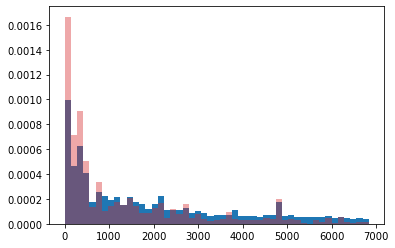

In [60]:
plot_bins(usrvidx_resvidx_tups_pos_SFCS_sam)

### Create negative synthetic examples

In [54]:
#Through DIST method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_neg_DIST = filter_atts(gur, usrvidx_resvidx_tups_, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_DIST))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_DIST))

Num of neg examples: 22325
Covered resources: 0.8394736842105263


In [55]:
#Through SFCS method
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=2, sd=13)
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.05, thmax=0.2)
usrvidx_resvidx_tups_neg_SFCS = filter_atts(gur, usrvidx_resvidx_tups_, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_SFCS))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_SFCS))

Num of neg examples: 5106
Covered resources: 0.20833333333333334


In [56]:
#Through RANDOM method
usrvidx_resvidx_tups = get_non_entries(gur, numentries=20000, sd=13)
usrvidx_resvidx_tups_neg_RANDOM = filter_atts(gur, usrvidx_resvidx_tups, minth=0, maxth=3)
print('Num of neg examples:', len(usrvidx_resvidx_tups_neg_RANDOM))
print('Covered resources:', cov_resources(usrvidx_resvidx_tups_neg_RANDOM))

Num of neg examples: 4575
Covered resources: 0.4570175438596491


Get subset of negative examples

In [61]:
num_neg_examples = 1600 #Because AZKAG has 32K entries
random.seed(13)
usrvidx_resvidx_tups_neg_DIST_sam = random.sample(usrvidx_resvidx_tups_neg_DIST,num_neg_examples)
random.seed(13)
usrvidx_resvidx_tups_neg_SFCS_sam = random.sample(usrvidx_resvidx_tups_neg_SFCS,num_neg_examples)
random.seed(13)
usrvidx_resvidx_tups_neg_RANDOM_sam = random.sample(usrvidx_resvidx_tups_neg_RANDOM,num_neg_examples)

Plot some distributions

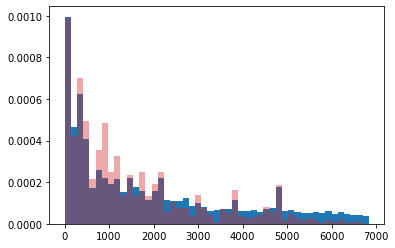

In [62]:
plot_bins(usrvidx_resvidx_tups_neg_SFCS_sam)

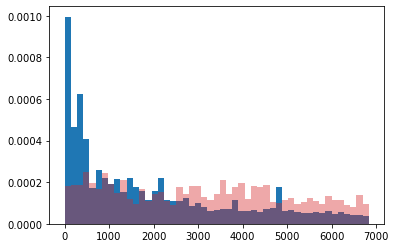

In [63]:
plot_bins(usrvidx_resvidx_tups_neg_RANDOM_sam)

In [83]:
def print_measures(num_pos, num_neg, num_truepos, num_falsepos):
    print('TPR', num_truepos/num_pos)
    print('FPR', num_falsepos/num_neg)
    recall = num_truepos/num_pos
    precision = num_truepos/(num_truepos+num_falsepos)
    fscore = 2*recall*precision/(recall+precision)
    print('Precision:', precision)
    print('Fscore:', fscore)
    
    num_trueneg = num_neg - num_falsepos
    acc = (num_truepos+num_trueneg)/(num_pos+num_neg)
    print('Accuracy:', acc)

### Evaluate biclique graph patterns

In [64]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('Total bicliques:', len(bcs))

Total bicliques: 17563


In [65]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 1:
        nusr = len(bc.get_usrids())
        nres = len(bc.get_resids())
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 12263


In [66]:
with open('data_structures/azkag_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

In [67]:
bcid_to_bc = {bc.get_id():bc for bc in subbcs}
gps = bcg.dfs(bcgraph, bcid_to_bc, sa=1)
print('Num graph patterns:', len(gps))

Num graph patterns: 6886


In [68]:
gps_final = []
for gpidx,gp in enumerate(gps):
    if len(gp[1]) < 50:
        gps_final.append(gp)

gps_final = [gp for gp in gps_final if len(gp[0])>1]

In [69]:
len(gps_final)

6375

In [70]:
#Create mappings
rules = [gp[0] for gp in gps_final]

bcid_to_ruleidxs = dict()
for ruleidx,gp in enumerate(gps_final):
    for bcid in gp[1]:
        if not bcid in bcid_to_ruleidxs:
            bcid_to_ruleidxs[bcid] = []
        bcid_to_ruleidxs[bcid].append(ruleidx)
        
#Agregado debido que ahora cargo el grafo de respaldo
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx
    
resid_to_bcids = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    resids_ = bc.get_resids()
    for resid in resids_:
        if not resid in resid_to_bcids:
            resid_to_bcids[resid] = []
        resid_to_bcids[resid].append(bcid) 

In [77]:
def evaluate_bgp(gur, usrvidx_resvidx_tups):

    num_valid = 0
    num_trues = 0

    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if resid in resid_to_bcids:
            ruleidxs = set()
            for bcid in resid_to_bcids[resid]:
                if bcid in bcid_to_ruleidxs:
                    ruleidxs |= set(bcid_to_ruleidxs[bcid])

            ruleidxs = list(ruleidxs)

            if len(ruleidxs) > 0:
                num_valid += 1

            for ruleidx in ruleidxs:
                rule = rules[ruleidx]
                if len(set(usrattvals)&set(rule)) == len(rule):
                        num_trues += 1
                        break
                        
    return num_valid, num_trues
            


In [79]:
#Pos: dist, Neg: dist
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_DIST_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.8825
FPR 0.264375
Precision: 0.7694822888283379
Fscore: 0.8221251819505093
Accuracy: 0.8090625


In [80]:
#Pos: dist, Neg: random
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.8825
FPR 0.0875
Precision: 0.9097938144329897
Fscore: 0.8959390862944162
Accuracy: 0.8975


In [78]:
#Pos: sfcs, Neg: sfcs
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_SFCS_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.8675
FPR 0.216875
Precision: 0.8
Fscore: 0.8323838080959521
Accuracy: 0.8253125


In [81]:
#Pos: sfcs, Neg: random
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.8675
FPR 0.0875
Precision: 0.9083769633507853
Fscore: 0.887468030690537
Accuracy: 0.89


### Evaluation frequent patterns

In [82]:
global_f = 5
resid_to_valsentries,resid_to_patterns=\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [84]:
def evaluate_fp(gur, usrvidx_resvidx_tups):
    num_valid = 0
    num_trues = 0
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if len(resid_to_patterns[resid]) > 0:
            num_valid += 1

        for rule in resid_to_patterns[resid]:
            if len(set(usrattvals)&set(rule)) == len(rule):
                    num_trues += 1
                    break
                    
    return num_valid, num_trues
    

In [85]:
#Pos: dist, Neg: dist
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_DIST_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.596875
FPR 0.07875
Precision: 0.883441258094357
Fscore: 0.712420738530399
Accuracy: 0.7590625


In [86]:
#Pos: dist, Neg: random
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_DIST_sam)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.596875
FPR 0.0175
Precision: 0.9715157680569685
Fscore: 0.7394502516453736
Accuracy: 0.7896875


In [87]:
#Pos: sfcs, Neg: sfcs
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_SFCS_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.585
FPR 0.095
Precision: 0.8602941176470589
Fscore: 0.6964285714285714
Accuracy: 0.745


In [88]:
#Pos: sfcs, Neg: random
n = len(usrvidx_resvidx_tups_pos)
num_pos_valid, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos_SFCS_sam)
num_neg_valid, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_RANDOM_sam)
print_measures(len(usrvidx_resvidx_tups_pos), len(usrvidx_resvidx_tups_neg), num_truepos, num_falsepos)

TPR 0.585
FPR 0.0175
Precision: 0.970954356846473
Fscore: 0.7301092043681746
Accuracy: 0.78375
